In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torchvision import datasets

from models import Classifier, cross_entropy_with_grad
from optimizers import MomentumSGD
from layers import *

In [3]:
np.random.seed(42)

## Загрузим MNIST

In [4]:
train_dataset = datasets.MNIST('./data', train=True, download=True)
test_dataset = datasets.MNIST('./data', train=False, download=True)

X_train, y_train = train_dataset.data.numpy(), train_dataset.targets.numpy()
X_test, y_test = test_dataset.data.numpy(), test_dataset.targets.numpy()

## Посмотрим на картинки

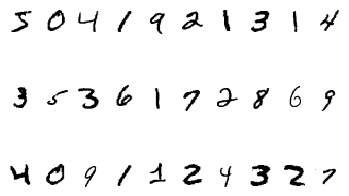

In [5]:
for plot_index in range(30):
    plt.subplot(3, 10, plot_index + 1)
    plt.imshow(X_train[plot_index], cmap=plt.cm.gray_r)
    plt.axis('off')

## Обработаем данные

In [6]:
X_train, X_test = X_train.astype(float, copy=False), X_test.astype(float, copy=False)

X_train, X_test = X_train / 255, X_test / 255

mean, std = 0.1307, 0.3081
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

X_train, X_test = X_train[:, :, :, np.newaxis], X_test[:, :, :, np.newaxis]
print(f'Train shape: {X_train.shape}, Test_shape: {X_test.shape}')

Train shape: (60000, 28, 28, 1), Test_shape: (10000, 28, 28, 1)


## Разобъём train выборку

In [7]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=1000, stratify=y_train, shuffle=True, random_state=42)

## Вспомогательные функции

In [8]:
def batches_indices(x, batch_size, shuffle=True):
    indices = np.arange(x.shape[0])
    if shuffle:
        np.random.shuffle(indices)
    sections = np.arange(batch_size, x.shape[0], batch_size)
    return np.array_split(indices, sections)

In [9]:
def compute_accuracy(X, y, batch_size, model):
    pred = np.zeros_like(y)
    for batch_indices in batches_indices(X, batch_size, shuffle=False):
        pred[batch_indices] = np.argmax(model(X[batch_indices]), axis=1)
    return accuracy_score(y, pred)

In [10]:
def plot_loss_history(train_history, valid_history):
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(train_history)), train_history, label='train')
    plt.plot(range(len(valid_history)), valid_history, label='validation')
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.legend(prop={'size': 14})
    plt.show()

# Train loop

In [11]:
def train(model, optimizer_class, epochs, batch_size, eval_batch_size, **optimizer_args):
    optimizer = optimizer_class(model.parameters(), **optimizer_args)
    
    train_losses, valid_losses = [], []
    
    best_valid_acc = 0.0
    best_parameters = None
    best_epoch = 0

    for epoch in range(epochs):
        # Train
        model.train()
        epoch_loss = 0.0
        for batch_indices in batches_indices(X_train, batch_size, shuffle=True):
            loss, grad = cross_entropy_with_grad(model(X_train[batch_indices]), y_train[batch_indices])
            optimizer.zero_grad()
            model.backward(grad)
            optimizer.step()
            epoch_loss += loss * len(batch_indices)
        train_losses.append(epoch_loss / len(y_train))

        # Evaluation
        model.eval()
        epoch_loss = 0.0
        for  batch_indices in batches_indices(X_validation, eval_batch_size, shuffle=False):
            loss, _ = cross_entropy_with_grad(model(X_validation[batch_indices]), y_validation[batch_indices])
            epoch_loss += loss * len(batch_indices)
        valid_losses.append(epoch_loss / len(y_validation))
        train_acc = compute_accuracy(X_train, y_train, eval_batch_size, model)
        valid_acc = compute_accuracy(X_validation, y_validation, eval_batch_size, model)
        if best_valid_acc < valid_acc:
            best_valid_acc = valid_acc
            best_parameters = [parameter.value.copy() for parameter in model.parameters()]
            best_epoch = epoch
        
        print(f'Epoch {epoch} | Train loss {train_losses[-1]} | Validation loss {valid_losses[-1]} | Train accuracy {train_acc} | Validation accuracy {valid_acc}')
            
    print(f'\nЭпоха, на которой был достигнут наибольший Validation accuracy: {best_epoch}\n')
    for parameter, best_parameter in zip(model.parameters(), best_parameters):
        parameter.value = best_parameter
                            
    return train_losses, valid_losses

## Модель

In [12]:
model = Classifier([Conv2d(in_channels=1, out_channels=16, kernel_size=5),
                    MaxPool2d(2, 2),
                    ReLU(),
                    Conv2d(in_channels=16, out_channels=32, kernel_size=5),
                    MaxPool2d(2, 2),
                    ReLU(),
                    Flattener(),
                    Linear(32 * 4 * 4, 128),
                    ReLU(),
                    Dropout(p=0.5),
                    Linear(128, 10)])

## Тренируем

In [13]:
eval_batch_size = 1000

In [14]:
train_history, valid_history = train(model, MomentumSGD, epochs=4, batch_size=256, eval_batch_size=eval_batch_size, lr=0.01, momentum=0.9)

Epoch 0 | Train loss 0.4963902509862658 | Validation loss 0.11210995809535569 | Train accuracy 0.9436949152542373 | Validation accuracy 0.964
Epoch 1 | Train loss 0.16087448874690183 | Validation loss 0.07787199633525482 | Train accuracy 0.9627966101694915 | Validation accuracy 0.98
Epoch 2 | Train loss 0.11964119916455922 | Validation loss 0.06182649544664802 | Train accuracy 0.9683898305084746 | Validation accuracy 0.982
Epoch 3 | Train loss 0.09832009138693376 | Validation loss 0.05450079726839277 | Train accuracy 0.9737118644067797 | Validation accuracy 0.981

Эпоха, на которой был достигнут наибольший Validation accuracy: 2



## Посмотрим, как менялся Loss

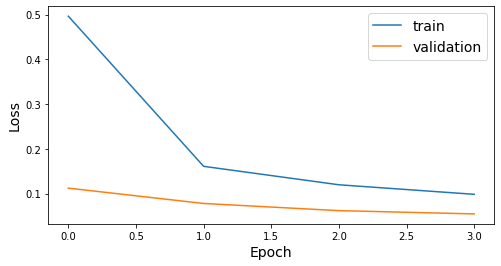

In [15]:
plot_loss_history(train_history, valid_history)

## Оценим модель на тестовой выборке

In [16]:
print(f'\nTest accuracy: {compute_accuracy(X_test, y_test, batch_size=eval_batch_size, model=model)}')


Test accuracy: 0.9838
